In [1]:
# resource used: https://towardsdatascience.com/sentiment-analysis-of-tweets-using-multinomial-naive-bayes-1009ed24276b

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable
from torch.optim.optimizer import Optimizer
import torch as t
import torch.nn as nn
import torch.nn.functional as F

from keras.preprocessing.text import Tokenizer

In [2]:
df_movie = pd.read_pickle("data/Movies_and_TV_5_purged_balanced_with_stopwords.pkl")

In [2]:
import pickle 
infile = open('./data/Movies_and_TV_5_purged_balanced_with_stopwords.pkl','rb')
df_movie = pickle.load(infile)
infile.close()

infile_eval = open('./data/Sports_and_Outdoors_5_balanced_with_stopwords.pkl','rb')
df_sports = pickle.load(infile_eval)
infile_eval.close()

print(df_movie)

         Unnamed: 0                                         reviewText  \
0                 0  [pearl, story, is, inspiring, to, say, the, le...   
1                 1                                 [love, this, show]   
2                 2  [whats, so, great, about, this, film, is, that...   
3                 3                                            [great]   
4                 4               [what, can, say, but, true, classic]   
...             ...                                                ...   
1080667     1080667  [have, seen, the, movie, in, english, on, cabl...   
1080668     1080668  [really, hard, to, give, this, four, star, rat...   
1080669     1080669  [spoiler, alert, here, sort, of, basically, ev...   
1080670     1080670  [season, was, quite, strong, and, rated, it, s...   
1080671     1080671                 [sorry, did, not, like, this, one]   

         overall  label  
0            5.0    2.0  
1            5.0    2.0  
2            5.0    2.0  
3      

In [3]:
# check how balanced the training dataset is
df_movie.groupby(['label']).count()

,Unnamed: 0,reviewText,overall
label,,,
0.0,365517,365517,365517
1.0,349638,349638,349638
2.0,365517,365517,365517


In [4]:
from sklearn.model_selection import train_test_split
# df_movie["reviewText"] = df_movie["reviewText"].apply(lambda x: " ".join(x))
train_X, test_X, train_y, test_y = train_test_split(df_movie['reviewText'], df_movie['label'], stratify=df_movie['label'], test_size=0.2)

In [5]:
print("Train shape : ",train_X.shape)
print("Test shape : ",test_X.shape)
print(train_X)

Train shape :  (864537,)
Test shape :  (216135,)
871392    [am, big, mortal, kombat, fan, and, am, glad, ...
785393    [image, entertainment, bought, madacy, in, can...
205270                                                   []
207708    [really, loved, this, movie, and, would, recom...
898534    [kind, of, stupid, and, not, very, entertainin...
                                ...                        
219688    [this, is, great, dvd, to, do, in, the, mornin...
645946                      [story, line, was, bit, boring]
892366    [everybody, already, knows, the, formula, ever...
513885    [visionary, this, is, beautiful, the, monsters...
120069    [have, watched, this, movie, few, times, and, ...
Name: reviewText, Length: 864537, dtype: object


In [6]:
max_features = 2000 # how many unique words to use (i.e num rows in embedding vector)
## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(list(train_X))
test_X = tokenizer.texts_to_sequences(list(test_X))

In [7]:
tr_data = tokenizer.sequences_to_texts(train_X)
test_data = tokenizer.sequences_to_texts(test_X)

In [8]:
# convert text data into a matrix of token counts
# ref: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
vectorizer = CountVectorizer()

x_train = vectorizer.fit_transform(tr_data).toarray()
x_test = vectorizer.transform(test_data).toarray()

In [9]:
# transform a count matrix to a normalized tf-idf representation
# ref: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
transformer = TfidfTransformer()
x_train = transformer.fit_transform(x_train).toarray()
x_test = transformer.transform(x_test).toarray()

In [10]:
y_train = np.array(train_y)
y_test = np.array(test_y)

In [11]:
# initialize and train classifier
classifier = MultinomialNB()
classifier.fit(x_train, y_train)

MultinomialNB()

In [12]:
prediction_test = classifier.predict(x_test)
val_preds = classifier.predict_proba(x_test)
accuracy_test = np.mean(prediction_test==y_test)
print("Accuracy (test): " + str(accuracy_test * 100) + "%")

Accuracy (test): 67.46015221967751%


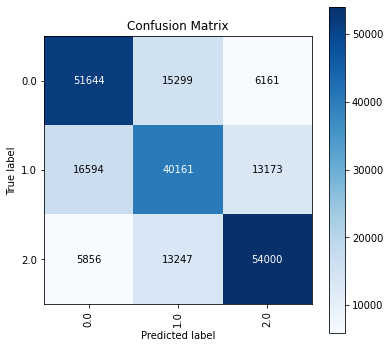

In [14]:
import scikitplot as skplt
import matplotlib.pyplot as plt
y_true = [x for x in y_test]
y_pred = [x for x in val_preds.argmax(axis=1)]
skplt.metrics.plot_confusion_matrix(
    y_true, 
    y_pred,
    figsize=(6,6),x_tick_rotation=90)
plt.savefig("results/naivebayes_confmtx_test.png")

In [15]:
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, accuracy_score

print('Accuracy: {}'.format(accuracy_score(y_true, y_pred)))
print('F1: {}'.format(f1_score(y_true, y_pred, average = None)))
print('Precision: {}'.format(precision_score(y_true, y_pred, average = None)))
print('Recall: {}'.format(recall_score(y_true, y_pred, average = None)))
print(f'AUC: {roc_auc_score(y_true, val_preds, multi_class="ovr")}')


Accuracy: 0.6746015221967752
F1: [0.70169432 0.5793775  0.73751852]
Precision: [0.69700651 0.58452559 0.73635694]
Recall: [0.70644561 0.5743193  0.73868377]
AUC: 0.8462328645291564


# Evaluation

In [2]:
df_sports = pd.read_pickle("data/Sports_and_Outdoors_5_balanced_with_stopwords.pkl")

In [16]:
# save tools for evaluation
import pickle
with open('data/nb_tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('data/nb_countvectorizer.pkl', 'wb') as handle:
    pickle.dump(vectorizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('data/nb_tfidf.pkl', 'wb') as handle:
    pickle.dump(transformer, handle, protocol=pickle.HIGHEST_PROTOCOL)

pickle.dump(classifier, open('nbclassifier.pkl', 'wb'))

In [3]:
import pickle
with open('data/nb_tokenizer.pkl', 'rb') as handle:
    tokenizer = pickle.load(handle)
    
with open('data/nb_countvectorizer.pkl', 'rb') as handle:
    vectorizer = pickle.load(handle)

with open('data/nb_tfidf.pkl', 'rb') as handle:
    transformer = pickle.load(handle)

classifier = pickle.load(open('nbclassifier.pkl', 'rb'))

In [4]:
eval_X = df_sports['reviewText']
eval_X = tokenizer.texts_to_sequences(list(eval_X))
eval_data = tokenizer.sequences_to_texts(eval_X)

In [5]:
x_eval = vectorizer.transform(eval_data).toarray()

In [6]:
x_eval = transformer.transform(x_eval).toarray()

In [7]:
y_eval= np.array(df_sports['label'])

In [8]:
# evaluation on 'evaluation' data
prediction_eval = classifier.predict(x_eval)
val_preds_eval = classifier.predict_proba(x_eval)
accuracy_eval = np.mean(prediction_eval==y_eval)
print("Accuracy (evaluation): " + str(accuracy_eval * 100) + "%")

Accuracy (evaluation): 60.79817232146261%


Evaluation


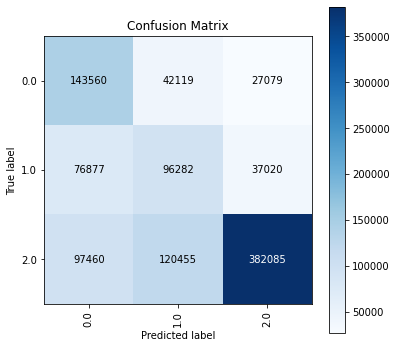

In [10]:
print("Evaluation")
import scikitplot as skplt
import matplotlib.pyplot as plt
y_true_eval = [x for x in y_eval]
y_pred_eval = [x for x in val_preds_eval.argmax(axis=1)]
skplt.metrics.plot_confusion_matrix(
    y_true_eval, 
    y_pred_eval,
    figsize=(6,6),x_tick_rotation=90)
plt.savefig("results/naivebayes_confmtx_eval.png")

In [11]:
print("Evaluation")
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, accuracy_score

print('Accuracy: {}'.format(accuracy_score(y_true_eval, y_pred_eval)))
print('F1: {}'.format(f1_score(y_true_eval, y_pred_eval, average = None)))
print('Precision: {}'.format(precision_score(y_true_eval, y_pred_eval, average = None)))
print('Recall: {}'.format(recall_score(y_true_eval, y_pred_eval, average = None)))
print(f'AUC: {roc_auc_score(y_true_eval, val_preds_eval, multi_class="ovr")}')


Evaluation
Accuracy: 0.6079817232146261
F1: [0.54106717 0.41055358 0.73043556]
Precision: [0.45159281 0.37195197 0.85633954]
Recall: [0.67475724 0.45809524 0.63680833]
AUC: 0.7949740100845789


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import OneHotEncoder

# Creating OneHotEncoded labels for multiclasss plots
enc = OneHotEncoder(handle_unknown='ignore')
y_test = np.array(enc.fit_transform(np.array(y_true).reshape(-1, 1)).todense())

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 3
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], val_preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver operating characteristic example (class {i})')
    plt.legend(loc="lower right")
    plt.show()